In [1]:
from grizli import combine
import sympy as sp
from astropy.io import fits
from astropy.cosmology import Planck13 as cosmo
from astropy.table import Table
from scipy.interpolate import interp1d, interp2d
from scipy.ndimage import interpolation
from astropy import wcs
import pysynphot as S
import matplotlib.pyplot as plt
from matplotlib import gridspec
from glob import glob
import seaborn as sea
import numpy as np
import pandas as pd
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.2, as_cmap=True)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [47]:
# fp = '/Users/Vince.ec/Clear_data/flt_files/'
fp = '/Users/vestrada/Clear_data/flt_files/'

###read in all flt files
flt_list=glob(fp + 'ic*flt.fits')

###select only imaging files in the south
imgflt=[]
for i in range(len(flt_list)):
    indat=fits.open(flt_list[i])
    if indat[0].header['OBSTYPE'] ==  'IMAGING' and indat[0].header['DEC_TARG'] < 0 and indat[0].header['TARGNAME'] == 'ERSPRIME':
        imgflt.append(flt_list[i])
#         print indat[0].header['TARGNAME']

In [26]:
### combine all flts into one fits file
combine.combine_flt(files=imgflt,output='../field_fits/ERSPRIME_com.fits')

Maximum shift (x, y) = ( 283.4,  186.3), pad=300
  1 /Users/vestrada/Clear_data/flt_files/icxt19o9q_flt.fits    0.0    0.0     302.94
  2 /Users/vestrada/Clear_data/flt_files/icxt19odq_flt.fits  -13.6    3.0     227.94
  3 /Users/vestrada/Clear_data/flt_files/icxt20faq_flt.fits  283.3 -154.7     302.94
  4 /Users/vestrada/Clear_data/flt_files/icxt20feq_flt.fits  269.5 -151.5     227.94
  5 /Users/vestrada/Clear_data/flt_files/icxt21baq_flt.fits  283.4 -154.7     302.94
  6 /Users/vestrada/Clear_data/flt_files/icxt21bfq_flt.fits  269.6 -151.6     227.94
  7 /Users/vestrada/Clear_data/flt_files/icxt22ppq_flt.fits -131.7  183.1     302.94
  8 /Users/vestrada/Clear_data/flt_files/icxt22ptq_flt.fits -145.2  186.3     227.94
  9 /Users/vestrada/Clear_data/flt_files/icxt23pyq_flt.fits -131.7  183.2     302.94
 10 /Users/vestrada/Clear_data/flt_files/icxt23q2q_flt.fits -145.3  186.2     227.94


In [48]:
### load in combined fits file
fields = ['GS1','GS2','GS3','GS4','GS5','ERSPRIME','GN1','GN2','GN3','GN4','GN5','GN7']

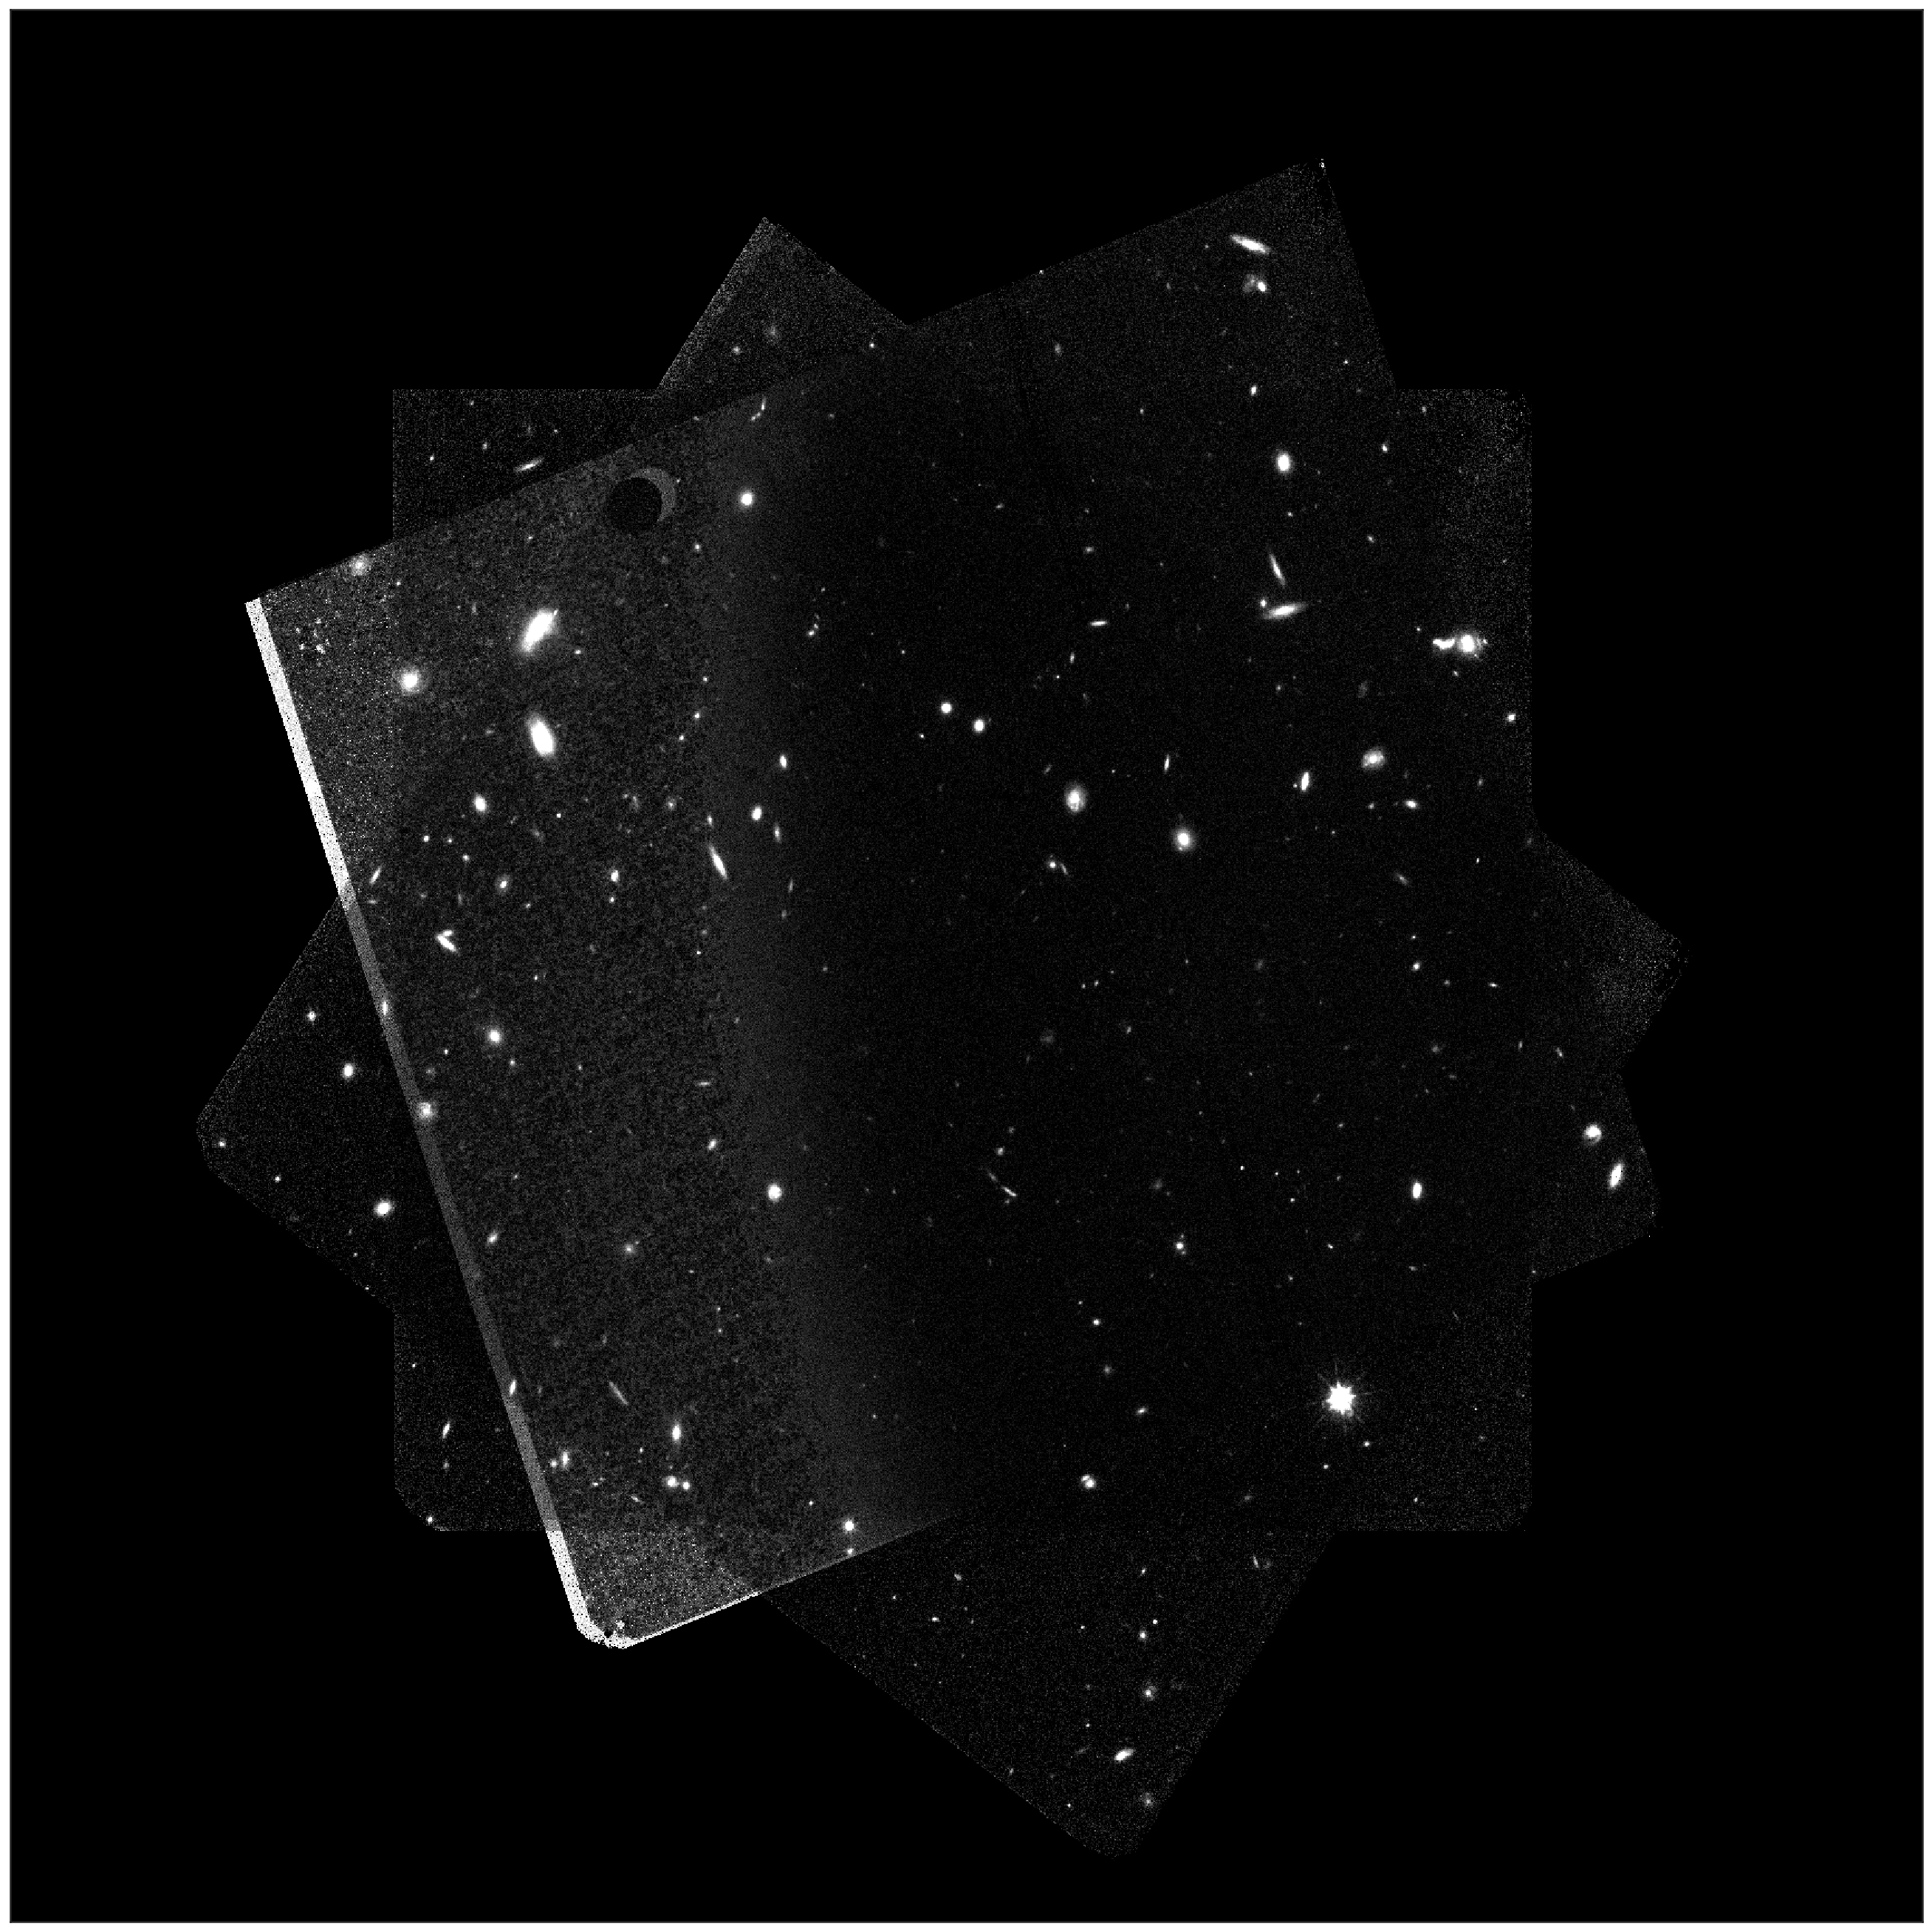

In [88]:
### plot the fields
for i in fields:
    img_data = fits.open('../field_fits/{0}_com.fits'.format(i))
    img = img_data[1].data
    w = img.shape[0]
    h = img.shape[1]

    fig = plt.gcf()
    DPI = fig.get_dpi()
    fig.set_size_inches(w/float(DPI),h/float(DPI))
    plt.imshow(np.arcsinh(img)*-1,vmin=-0.8,vmax=0,cmap='binary')
    plt.yticks([])
    plt.xticks([])
    plt.savefig('../field_fits/{0}.pdf'.format(i),bbox_inches = 'tight')


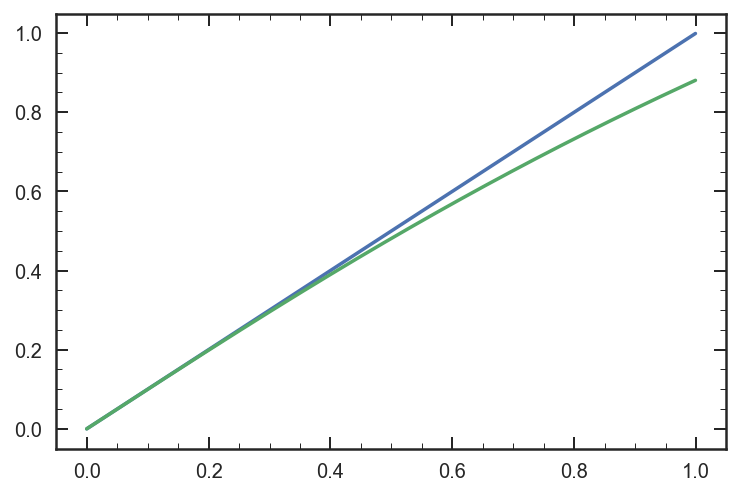

In [35]:
x = np.arange(0,1,.001)
plt.plot(x,x)
plt.plot(x,np.arcsinh(x))

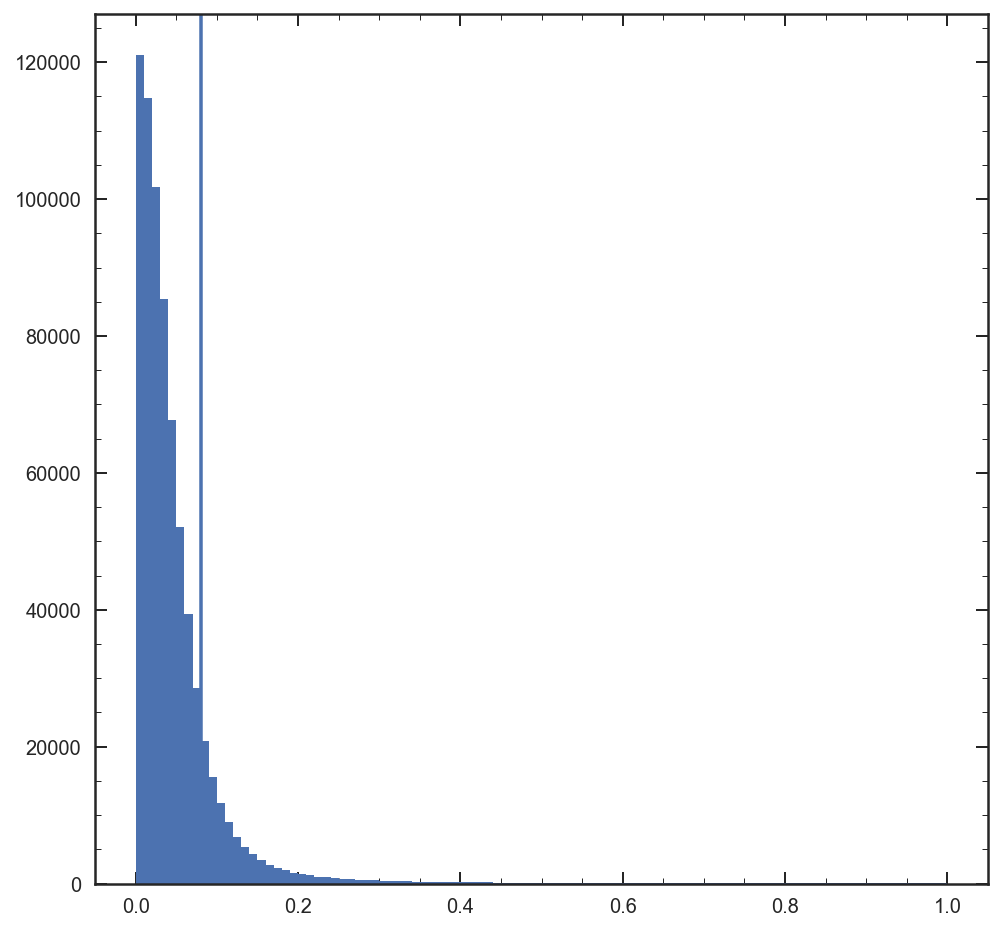

In [15]:
img_filt = np.reshape(img,len(img[0])*len(img[1]))
img_filt = img_filt[img_filt < 1]
img_filt = img_filt[img_filt > 0]

plt.figure(figsize=[8,8])
plt.hist(img_filt , 100 )
plt.axvline(0.08)

# Create catalogs

In [38]:
def Source_present(fits_file, ra, dec):
    w = wcs.WCS(fits_file[1].header)
    [pos] = w.wcs_world2pix([[ra, dec]], 1)
    return pos

In [7]:
SIDF = pd.read_pickle('../webapp/south_img_DF_vr.pkl')
NIDF = pd.read_pickle('../webapp/north_img_DF_vr.pkl')
goodss_mag = Table.read('../../../Clear_data/goodss_3dhst.v4.3.cat', format = 'ascii').to_pandas()
goodsn_mag = Table.read('../../../Clear_data/goodsn_3dhst.v4.3.cat', format = 'ascii').to_pandas()

In [8]:
img_data = fits.open('../field_fits/ERSPRIME_com.fits')

gid = []
ra = []
dec = []
x_flt = []
y_flt = []

for i in SIDF.index:
    if 'ERSPRIME' in SIDF.field[i]:
        RA = goodss_mag.ra[goodss_mag.id == SIDF.id[i]].values[0]
        ra.append(RA)
        DEC = goodss_mag.dec[goodss_mag.id == SIDF.id[i]].values[0]
        dec.append(DEC)
        gid.append(goodss_mag.id[goodss_mag.id == SIDF.id[i]].values[0])
#         pos = Source_present(img_data, RA, DEC)
#         x_flt.append(pos[0])
#         y_flt.append(pos[1])

# Mosaic pull

In [163]:
reference_image=fits.open('/Users/vestrada/Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F125W_orig_sci.fits')
segment_map=fits.open('/Users/vestrada/Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F160W_seg.fits')

In [9]:
ers_db = pd.DataFrame({'gid':gid,'ra':ra,'dec':dec})

In [220]:
def Copy(img, seg_map, img_copy, gids):
    I = np.array(img)
    SM = np.array(seg_map)
    IC = np.array(img_copy)
    
    for i in range(len(gids)):
        pos = np.argwhere(SM == gids[i])
        for ii in range(len(pos)):
            IC[pos[ii][0]][pos[ii][1]] = I[pos[ii][0]][pos[ii][1]]
    return IC
    
def Shrink(img):
    sy = sum(img.T)
    cd = 0
    cu = 0

    for i in range(len(sy)):
        if sy[i] == 0:
            cd +=1
        else:
            break

    for i in range(len(sy[::-1])):
        if sy[::-1][i] == 0:
            cu +=1
        else:
            break

    sy = sum(img)
    cr = 0
    cl = 0

    for i in range(len(sy)):
        if sy[i] == 0:
            cr +=1
        else:
            break

    for i in range(len(sy[::-1])):
        if sy[::-1][i] == 0:
            cl +=1
        else:
            break
    return img[cd:-cu+1,cr:-cl+1]

In [124]:
#### Test script

In [185]:
x=np.random.rand(1000,1000)
x_seg=np.zeros([1000,1000])
x_seg[20:40,140:170] = int(1)
x_seg[5:43,380:400] = int(2)
x_seg[160:189,702:724] = int(3)
x_seg[220:240,40:70] = int(4)
x_seg[333:353,370:390] = int(5)
x_seg[260:289,802:834] = int(6)
x_seg[520:540,40:70] = int(7)
x_seg[555:583,300:339] = int(8)
x_seg[603:693,600:640] = int(9)
x_seg[701:730,220:250] = int(10)
x_seg[705:733,320:340] = int(11)
x_seg[860:889,952:974] = int(12)

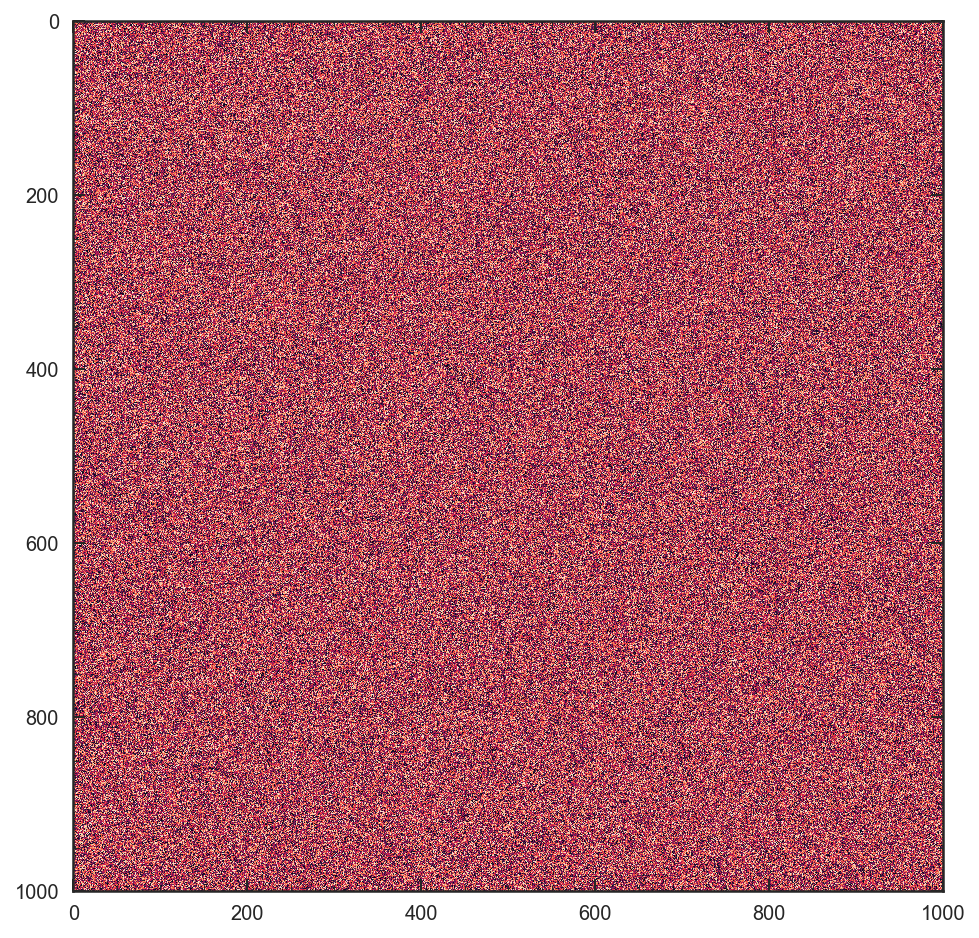

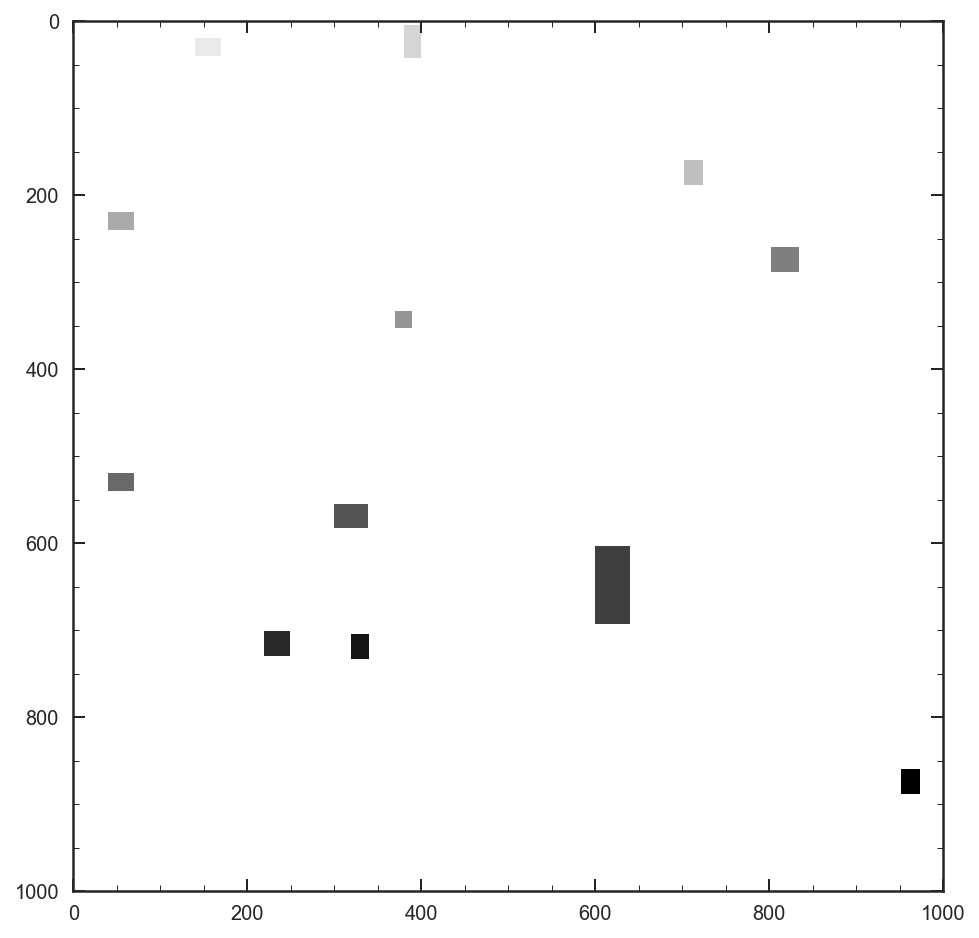

In [187]:
plt.figure(figsize=[8,8])
plt.imshow(x)

plt.figure(figsize=[8,8])
plt.imshow(x_seg,cmap='binary')

In [221]:
y = np.zeros(x.shape)
y = Copy(x,x_seg,y,[10,8,11])
ys = Shrink(y)

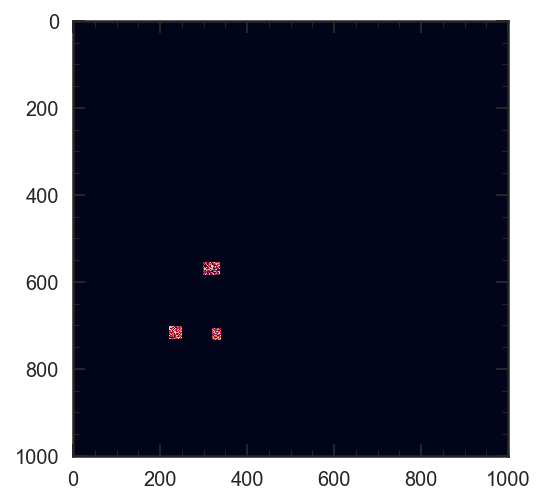

In [222]:
plt.imshow(y)

In [209]:
sy = sum(y.T)
cd = 0
cu = 0

for i in range(len(sy)):
    if sy[i] == 0:
        cd +=1
    else:
        break
        
for i in range(len(sy[::-1])):
    if sy[::-1][i] == 0:
        cu +=1
    else:
        break
        
sy = sum(y)
cr = 0
cl = 0

for i in range(len(sy)):
    if sy[i] == 0:
        cr +=1
    else:
        break
        
for i in range(len(sy[::-1])):
    if sy[::-1][i] == 0:
        cl +=1
    else:
        break

In [212]:
cl

660

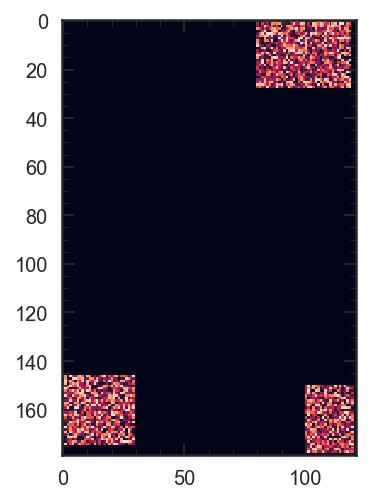

In [217]:
plt.imshow(y[cd:-cu+1,cr:-cl+1])

In [219]:
print(y[cd:-cu,cr:-cl])

[[0.         0.         0.         ... 0.76208843 0.50052337 0.        ]
 [0.         0.         0.         ... 0.74979752 0.59835539 0.        ]
 [0.         0.         0.         ... 0.64848588 0.40616971 0.        ]
 ...
 [0.         0.         0.         ... 0.66135218 0.11628669 0.74444442]
 [0.         0.         0.         ... 0.32388482 0.50202434 0.54161572]
 [0.         0.         0.         ... 0.90899886 0.56347426 0.66517956]]


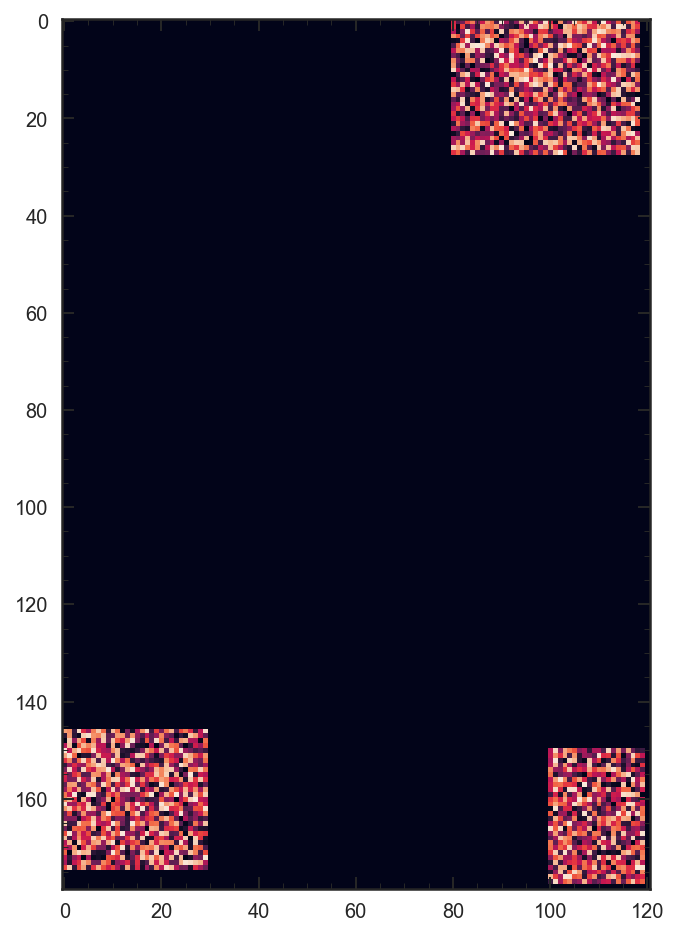

In [224]:
plt.figure(figsize=[8,8])

plt.imshow(ys)

In [ ]:
### Trial

In [166]:
ERS_img = np.zeros(reference_image[0].data.shape)
ERS_img = Copy(reference_image[0].data,segment_map[0].data,ERS_img,ers_db.gid.values[0:5])
ERS_img = Shrink(ERS_img)

In [168]:
ERS_img.shape

(278, 301)

([], <a list of 0 Text xticklabel objects>)

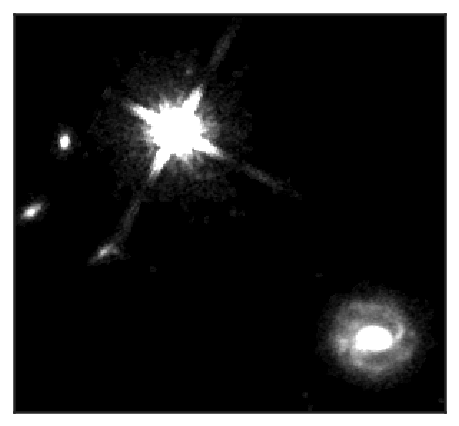

In [169]:
fig = plt.gcf()
DPI = fig.get_dpi()
fig.set_size_inches(278/float(DPI),301/float(DPI))
# plt.figure(figsize=[10,10])
plt.imshow(ERS_img,vmin=0,vmax=0.1,cmap='gray')
plt.yticks([])
plt.xticks([])